# SARIMA Model Performance Evaluation

Evaluate pre-trained SARIMA models in `trained_models/` using the held-out test portion (last 20% of each series).

**Metrics:**
- **MAE** – Mean Absolute Error
- **RMSE** – Root Mean Squared Error
- **MAPE** – Mean Absolute Percentage Error

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MODELS_DIR = "trained_models"
INDEX_FILE = os.path.join(MODELS_DIR, "models_index.pkl")
OUTPUT_FILE = "model_evaluation_results.csv"

In [2]:
def compute_metrics(y_true, y_pred):
    """Compute MAE, RMSE, MAPE. Handles zeros in y_true for MAPE."""
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    nonzero_mask = y_true != 0
    if nonzero_mask.any():
        mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
    else:
        mape = np.nan
    
    return mae, rmse, mape

In [3]:
if not os.path.exists(INDEX_FILE):
    raise FileNotFoundError(f"Models index not found at {INDEX_FILE}. Run 'python train_models.py' first.")

with open(INDEX_FILE, 'rb') as f:
    models_index = pickle.load(f)

print(f"Evaluating {len(models_index)} models using held-out test set (last 20%)")

Evaluating 12 models using held-out test set (last 20%)


In [4]:
results = []

for medication, info in models_index.items():
    model_file = info.get('file')
    if not model_file or not os.path.exists(model_file):
        print(f"[SKIP] {medication}: model file not found")
        continue
    
    try:
        with open(model_file, 'rb') as f:
            model_data = pickle.load(f)
        
        model = model_data.get('model')
        series = model_data.get('series')
        apply_log = model_data.get('apply_log', False)
        train_size_idx = model_data.get('train_size_idx', int(len(series) * 0.8))
        trained_date = model_data.get('trained_date', 'unknown')
        
        if model is None or series is None or train_size_idx >= len(series) - 1:
            print(f"[SKIP] {medication}: insufficient data")
            continue
        
        y_test = series.iloc[train_size_idx:]['y'].values
        forecast = model.get_forecast(steps=len(y_test))
        y_pred = forecast.predicted_mean.values
        
        if apply_log:
            y_test_orig = np.expm1(y_test)
            y_pred_orig = np.expm1(y_pred)
        else:
            y_test_orig = y_test
            y_pred_orig = y_pred
        
        mae, rmse, mape = compute_metrics(y_test_orig, y_pred_orig)
        
        results.append({
            'medication': medication,
            'n_train': train_size_idx,
            'n_test': len(y_test),
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'trained_date': trained_date
        })
        
    except Exception as e:
        print(f"[FAIL] {medication}: {e}")

df = pd.DataFrame(results)
print(f"\nEvaluated {len(df)} models successfully.")


Evaluated 12 models successfully.


In [5]:
df

,medication,n_train,n_test,mae,rmse,mape,trained_date
0,Amlodipine Tablets,37,10,1136.138294,1399.249038,31.423197,2026-02-12T01:19:17.787314
1,Amoxicillin Capsules,37,10,1103.430983,1398.768290,36.064611,2026-02-12T01:19:17.909020
2,Artemether-Lumefantrine,37,10,1240.904145,1508.255500,55.885384,2026-02-12T01:19:18.001121
3,Azithromycin Tablets,37,10,744.224842,1324.167463,15.634508,2026-02-12T01:19:18.141828
4,Ceftriaxone Injection,37,10,625.877530,842.566109,16.180303,2026-02-12T01:19:18.265034
5,Co-trimoxazole Tablets,37,10,1386.685370,1538.431580,33.584302,2026-02-12T01:19:18.377245
6,Doxycycline Capsules,37,10,1842.249130,2116.976653,74.614679,2026-02-12T01:19:18.563687
7,Ibuprofen Tablets,37,10,1116.809171,1350.086094,45.013569,2026-02-12T01:19:18.659212
8,Metformin Tablets,36,10,1025.221085,1445.157879,21.590000,2026-02-12T01:19:18.761956
9,Omeprazole Capsules,37,10,633.874744,782.253789,15.036132,2026-02-12T01:19:18.870178


In [6]:
print("Overall averages:")
print(f"  MAE:  {df['mae'].mean():,.1f} (median: {df['mae'].median():,.1f})")
print(f"  RMSE: {df['rmse'].mean():,.1f} (median: {df['rmse'].median():,.1f})")
print(f"  MAPE: {df['mape'].mean():.1f}% (median: {df['mape'].median():.1f}%)")
print(f"\nBest MAE:  {df.loc[df['mae'].idxmin(), 'medication']} ({df['mae'].min():,.1f})")
print(f"Worst MAE: {df.loc[df['mae'].idxmax(), 'medication']} ({df['mae'].max():,.1f})")

Overall averages:
  MAE:  1,058.0 (median: 1,110.1)
  RMSE: 1,321.5 (median: 1,387.1)
  MAPE: 35.0% (median: 32.5%)

Best MAE:  Ceftriaxone Injection (625.9)
Worst MAE: Doxycycline Capsules (1,842.2)


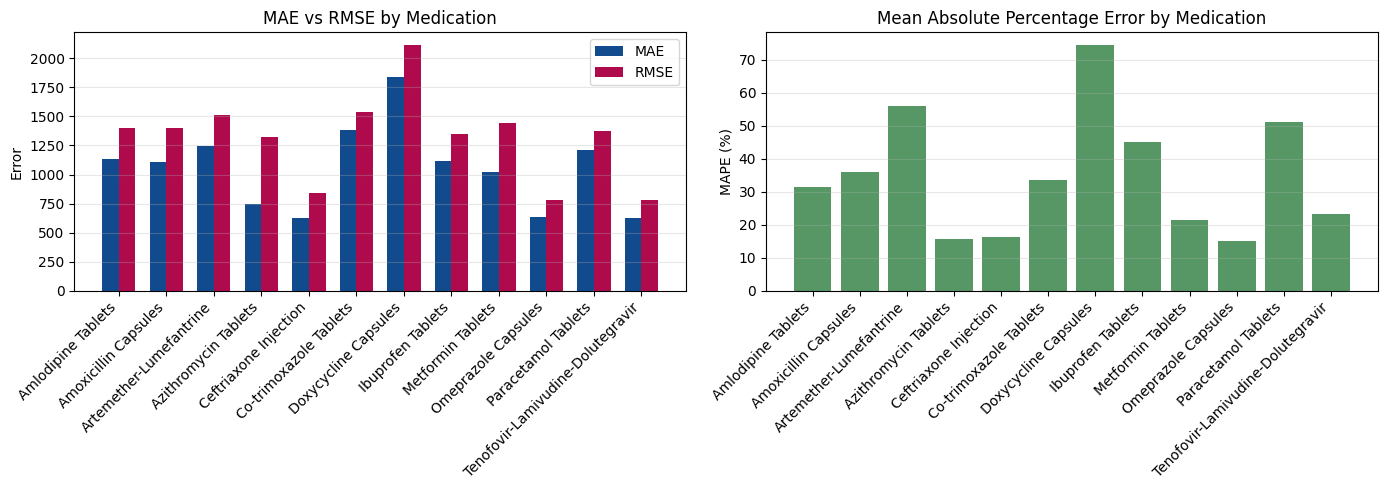

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = df['medication'].values
x = np.arange(len(names))
width = 0.35

axes[0].bar(x - width/2, df['mae'], width, color='#124b8d', label='MAE')
axes[0].bar(x + width/2, df['rmse'], width, color='#af0b4c', label='RMSE')
axes[0].set_xticks(x)
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel('Error')
axes[0].set_title('MAE vs RMSE by Medication')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, df['mape'], color='#2d7d3e', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_title('Mean Absolute Percentage Error by Medication')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv(OUTPUT_FILE, index=False)
print(f"Results saved to {OUTPUT_FILE}")